# Webscraping from LA County COVID-19 Site and Creating Plot
- Patty Jula, <pattyjula@gmail.com>

LA County Public Health has been providing daily counts of the number of cases and rates Los Angeles County from COVID-19. This script provides a way to download the day's counts, load to a database, in this case a CSV, and create a plot. 

Source: <http://publichealth.lacounty.gov/media/Coronavirus/locations.htm>
## Note:
This type of webscraping is only available from sites that reveal their source code. The best practice is to ask permission before scraping so an organization's servers are not overloaded.

In [51]:
# Dependencies
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams

In [52]:
# Boilerplate code
url = 'http://publichealth.lacounty.gov/media/Coronavirus/locations.htm'
res = requests.get(url)
html_page = res.content

roundup_next_pow_10 = lambda x: 10**(
    int(np.log(x)/np.log(10)) + 1)

## Parse through the html

In [53]:
soup = BeautifulSoup(html_page, 'html.parser')
#print(soup.prettify())


## Load data to a Pandas dataframe

In [54]:
# column names
column = ['location', 'count', 'rate']

# empty list
data = []
count = 0
table = soup.find("table", {"table table-striped table-bordered table-sm"})#.findAll('tr')
for element in table.findAll("tr"):
    count += 1
    if count > 29: # first 29 rows are not needed
        # find cells containing td
        cells = element.findAll("td")
        info = [cell.text for cell in cells] # get the cell text
        data.append(info) # append to data list


In [55]:
df = pd.DataFrame(data, columns= column,) # convert to dataframe
df = df[df.rate != '--'] # drop select records
#df.to_csv("county.csv", encoding='utf-8', index=False)

In [56]:
# handle empty cells, they are not read as NaN by default
df['rate'].replace('', np.nan, inplace=True)
# now they can be deleted
df.dropna(subset=['rate'], inplace=True)

In [57]:
df.to_csv("county.csv", encoding='utf-8', index=False)
df = pd.read_csv('county.csv', index_col=False)
#df.to_csv("county.csv", encoding='utf-8', index=False)
#df=df[df['location'].apply(lambda x: x.startswith('Los Angeles -'))]
df.rate.astype(float)
df = df.sort_values(by='rate',ascending=False)

df.head()

,location,count,rate
97,Los Angeles - Crestview,29,253.36
131,Los Angeles - Little Armenia,19,250.99
73,City of West Hollywood,86,240.24
114,Los Angeles - Hancock Park,39,237.44
81,Los Angeles - Bel Air,18,219.03


## Add today's date to the dataframe

In [58]:
import datetime
def today_date():
    '''
    utils:
    get the datetime of today
    '''
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
df['Date'] = today_date()

## foo

# bar

## Explicitly convert Dat field to date

In [59]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df2['count'] = d2['count'].str.replace(',', '').astype(int)
df['location'] = df.location.str.replace('City of ', '')
df['location'] = df.location.str.replace('Los Angeles - ', '')
df['location'] = df.location.str.replace('Unincorporated - ', '')


df.head() 


,location,count,rate,Date
97,Crestview,29,253.36,2020-04-07
131,Little Armenia,19,250.99,2020-04-07
73,West Hollywood,86,240.24,2020-04-07
114,Hancock Park,39,237.44,2020-04-07
81,Bel Air,18,219.03,2020-04-07


In [60]:
#df.to_csv("nbhrd_temp.csv", encoding='utf-8', index=False)
dfnew = df.nlargest(10, ['rate']) 
dfnew.head()

,location,count,rate,Date
97,Crestview,29,253.36,2020-04-07
131,Little Armenia,19,250.99,2020-04-07
73,West Hollywood,86,240.24,2020-04-07
114,Hancock Park,39,237.44,2020-04-07
81,Bel Air,18,219.03,2020-04-07


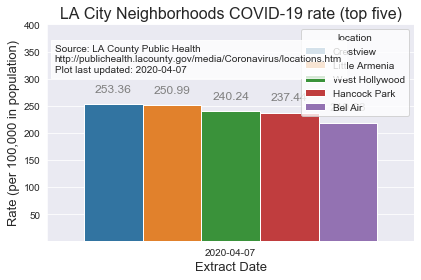

In [61]:
dfnew = df.nlargest(5, ['rate']) 
dfnew['Date'] = pd.to_datetime(dfnew['Date']).dt.date
#sns.set(style="whitegrid")
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(x="Date", y="rate", hue= 'location', data=dfnew)#,hue_order=pd.value_counts(df['rate']).iloc[:10])#, palette ="bright")#, color= 'Set2')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# Annotate bars
for p in ax.patches:
    #y = int("count")
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', fontsize=12, color='gray', xytext=(0, 15),
        textcoords='offset points')
#sns.set_ylabels("") 
plt.xlabel("Extract Date", size = 13)
plt.ylabel("Rate (per 100,000 in population)", size = 13)
#plt.yscale('log')
plt.title("LA City Neighborhoods COVID-19 rate (top five)", size = 16)
# bar lot
plt.ylim(1,400)
plt.tight_layout()
source_txt = """Source: LA County Public Health
http://publichealth.lacounty.gov/media/Coronavirus/locations.htm
Plot last updated: """
last_date = dfnew["Date"].max()
source_txt += last_date.strftime("%Y-%m-%d")
plt.figtext(0.02, 0.78, source_txt,transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))
, horizontalalignment='right') 
plt.savefig('neighborhood.png', dpi=400) 
plt.show()

## Now let's deal with the existing database

### This existing database contains previous day's data

In [62]:
dfDB = pd.read_csv("neighborhood_storage.csv", parse_dates=['Date'], dayfirst=True)
#dfDB.set_index('Date')
#dfDB.head()

## If current day's date is already in database, delete it

In [63]:
for index, row in dfDB.iterrows():
    #print(row['Date'])
    if row['Date'] == today_date():
        #print('Found')
        dfDB.drop(index, inplace=True)
    else:
        pass

## Then let's add the newly scraped data to the database

In [64]:
df= dfDB.append(df, ignore_index = True,sort=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.sort_values(by='Date',ascending=True)
#del df['Unnamed: 0']
#df['Date'] = pd.to_datetime(df['Date']).dt.date
print('rate: per 100,000')
df.head(20)

rate: per 100,000


,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73
5,2020-04-04,21,Century City,173.38
6,2020-04-04,129,Melrose,166.16
7,2020-04-04,17,South Carthay,160.44
8,2020-04-04,12,Little Armenia,158.52
9,2020-04-04,46,Brentwood,147.12


In [65]:


#df.to_csv("neighborhood_storage.csv", encoding='utf-8', index=False)
df.head()

,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73


## Again, explicitly set date

In [66]:
#df['Date'] = df["Date"].apply(pd.to_datetime,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.sort_values('Date').nlargest(10, 'rate')
df2 = df.nlargest(20, ['rate']) 

df2.head(20)

,Date,count,location,rate
240,2020-04-07,29,Crestview,253.36
241,2020-04-07,19,Little Armenia,250.99
242,2020-04-07,86,West Hollywood,240.24
243,2020-04-07,39,Hancock Park,237.44
0,2020-04-04,37,Hancock Park,225.27
120,2020-04-05,37,Hancock Park,225.27
244,2020-04-07,18,Bel Air,219.03
245,2020-04-07,28,Carthay,208.67
246,2020-04-07,25,Beverly Crest,201.69
1,2020-04-04,24,Beverly Crest,193.63


# Create plot with seaborn

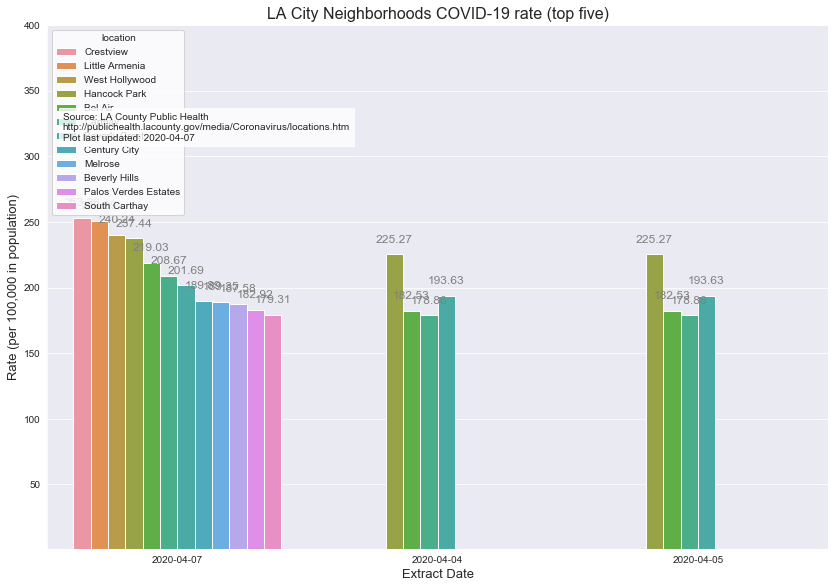

In [67]:
#sns.set(style="whitegrid")
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(x="Date", y="rate", hue= 'location', data=df2)#,hue_order=pd.value_counts(df['rate']).iloc[:10])#, palette ="bright")#, color= 'Set2')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# Annotate bars
for p in ax.patches:
    #y = int("count")
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', fontsize=12, color='gray', xytext=(0, 15),
        textcoords='offset points')
#sns.set_ylabels("") 
plt.xlabel("Extract Date", size = 13)
plt.ylabel("Rate (per 100,000 in population)", size = 13)
#plt.yscale('log')
plt.title("LA City Neighborhoods COVID-19 rate (top five)", size = 16)
# bar lot
plt.ylim(1,400)
plt.tight_layout()
source_txt = """Source: LA County Public Health
http://publichealth.lacounty.gov/media/Coronavirus/locations.htm
Plot last updated: """
last_date = df2["Date"].max()
source_txt += last_date.strftime("%Y-%m-%d")
plt.figtext(0.02, 0.78, source_txt,transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))
, horizontalalignment='right') 
plt.savefig('neighborhood.png', dpi=400) 
plt.show()

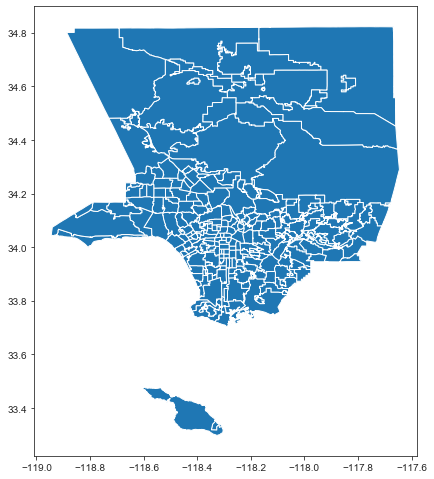

In [68]:
import geopandas
#url = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-current.geojson"
gdf = geopandas.read_file("./nghbrhdraw.shp")
#gdf = geopandas.read_file(url)
gdf.plot()
#gdf2 = gdf
#gdf2.to_file(driver = 'ESRI Shapefile', filename= './nghbrhdraw.shp')

In [69]:
#pip install geopandas
#gdf.to_csv("neighborhoods.csv")
gdf.head()


,kind,external_i,name,slug,set,metadata,resource_u,EDIT,geometry
0,L.A. County Neighborhood (Current),acton,Acton,acton-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 39.3391089485, ""type"": ""unincorporate...",/1.0/boundary/acton-la-county-neighborhood-cur...,None,"POLYGON ((-118.20262 34.53899, -118.18947 34.5..."
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,None,"POLYGON ((-118.30901 34.03741, -118.30041 34.0..."
2,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 8.14676029818, ""type"": ""standalone-ci...",/1.0/boundary/agoura-hills-la-county-neighborh...,None,"POLYGON ((-118.76193 34.16820, -118.72632 34.1..."
3,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 31.4626319451, ""type"": ""unincorporate...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,None,"POLYGON ((-118.25468 34.55830, -118.25551 34.5..."
4,L.A. County Neighborhood (Current),alhambra,Alhambra,alhambra-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 7.62381430605, ""type"": ""standalone-ci...",/1.0/boundary/alhambra-la-county-neighborhood-...,None,"POLYGON ((-118.12175 34.10504, -118.11687 34.1..."


In [70]:
#gdf.plot();
gdfNew = gdf.merge(df, left_on='name', right_on='location', how='inner')


In [71]:
gdfNew[["Date"]] = gdfNew[["Date"]].astype(str) 

In [72]:
#gdf.crs = "EPSG:4326"
gdfNew.head()

,kind,external_i,name,slug,set,metadata,resource_u,EDIT,geometry,Date,count,location,rate
0,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,None,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",2020-04-04,11,Adams-Normandie,129.61
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,None,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",2020-04-05,11,Adams-Normandie,129.61
2,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,None,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",2020-04-07,13,Adams-Normandie,153.18
3,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 8.14676029818, ""type"": ""standalone-ci...",/1.0/boundary/agoura-hills-la-county-neighborh...,None,"POLYGON ((-118.76193 34.16820, -118.72632 34.1...",2020-04-07,18,Agoura Hills,85.03
4,L.A. County Neighborhood (Current),alhambra,Alhambra,alhambra-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 7.62381430605, ""type"": ""standalone-ci...",/1.0/boundary/alhambra-la-county-neighborhood-...,None,"POLYGON ((-118.12175 34.10504, -118.11687 34.1...",2020-04-07,22,Alhambra,25.37


In [73]:
#gdf = gdf.to_crs(epsg=3857)
#import contextily as ctx


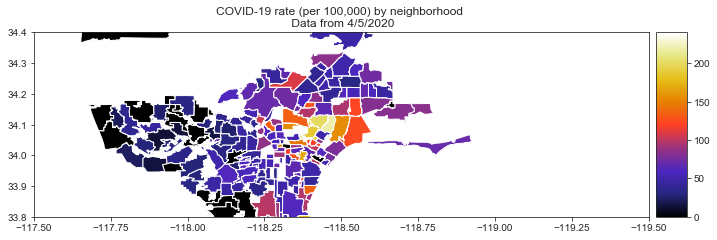

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#sns.set_style('darkgrid')
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27

fig, ax = plt.subplots(1, 1)
plt.title('COVID-19 rate (per 100,000) by neighborhood \n Data from 4/5/2020')
divider = make_axes_locatable(ax)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_ylim(33.8, 34.4)
ax.set_xlim(-117.5, -119.5)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdfNew.plot(column='rate', ax=ax, legend=True, cax=cax, cmap = 'CMRmap')

In [75]:
gdfNew.to_file(driver = 'ESRI Shapefile', filename= 'nghbrhd_data.shp')